# Feature Selection



In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import catboost 
from catboost import Pool
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from copy import deepcopy

from bartpy.sklearnmodel import SklearnModel
from bartpy.featureselection import SelectNullDistributionThreshold, SelectSplitProportionThreshold
from bartpy.diagnostics.features import *

%matplotlib inline

Text(0.5,1,'X v y')

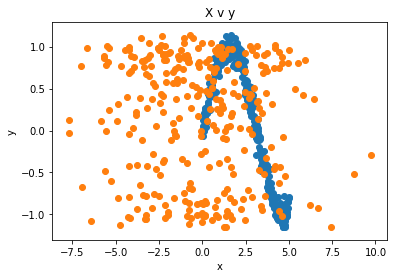

In [2]:
x = np.linspace(0, 5, 300)
X = np.random.normal(0, 3, size = 300 * 2).reshape(300, 2)
X[:, 0] = x
X = pd.DataFrame(X).sample(frac=1.0).values
y = np.random.normal(0, 0.1, size=300) + np.sin(X[:, 0])
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 1], y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("X v y")

# Sklearn API

Feature selection can be done in BartPy using the Sklearn selector API.  This allows for deep integration with the Sklearn pipelines

### Proportion Threshold

The simplest way to select features is to set a threshold on how often a variable is used in splits in the model trees.  The more times a tree appears in the model, the more likely it is that the feature is important and captures a meaningful pattern.

While this method is simple, the downside is that it is hard to set the threshold appropriately.  Cross validation is recommended

In [3]:
model = SklearnModel(n_samples=200, n_burn=50, n_trees=20, store_in_sample_predictions=False)
pipeline = make_pipeline(SelectSplitProportionThreshold(model, 0.3), model)
pipeline_model = pipeline.fit(X, y)

In [4]:
print("Feature Proportions", pipeline_model.named_steps["selectsplitproportionthreshold"].feature_proportions)
print("Is Kept", pipeline_model.named_steps["selectsplitproportionthreshold"]._get_support_mask())

Feature Proportions {0: 0.5030326004548901, 1: 0.19370735405610312}
Is Kept [ True False]


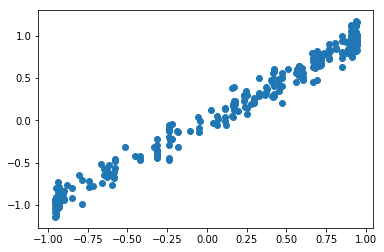

In [5]:
plt.scatter(model.predict(X), y)

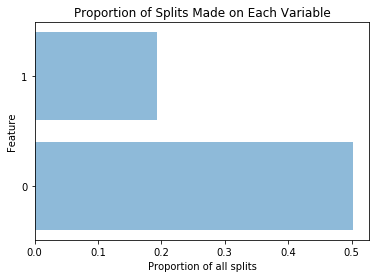

In [6]:
pipeline_model.named_steps["selectsplitproportionthreshold"].plot()

### Null Distribution Threshold

For a more principled analysis, BartPy implements the method described in https://repository.upenn.edu/cgi/viewcontent.cgi?article=1555&context=statistics_papers.

This is significantly more computationally expensive, but offers a principled way to set proportions

In [7]:
model = SklearnModel(n_samples=500, n_burn=200, n_trees=20, store_in_sample_predictions=False, n_jobs=-1)
pipeline = make_pipeline(SelectNullDistributionThreshold(model, 0.9, "local"), model)
pipeline_model = pipeline.fit(X, y)

In [8]:
print("Thresholds", pipeline_model.named_steps["selectnulldistributionthreshold"].thresholds)
print("Feature Proportions", pipeline_model.named_steps["selectnulldistributionthreshold"].feature_proportions)
print("Is Kept", pipeline_model.named_steps["selectnulldistributionthreshold"]._get_support_mask())

Thresholds {0: 0.3653314858511391, 1: 0.3371380713224034}
Feature Proportions {0: 0.5305938812237553, 1: 0.16946610677864427}
Is Kept [ True False]


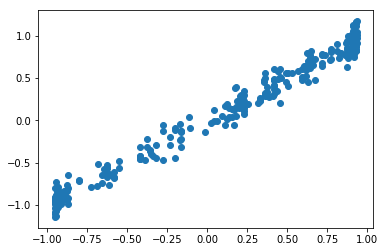

In [9]:
plt.scatter(model.predict(X), y)

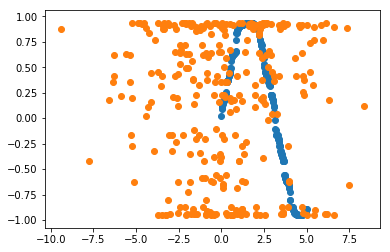

In [10]:
plt.scatter(X[:,0], model.predict(X))
plt.scatter(X[:,1], model.predict(X))

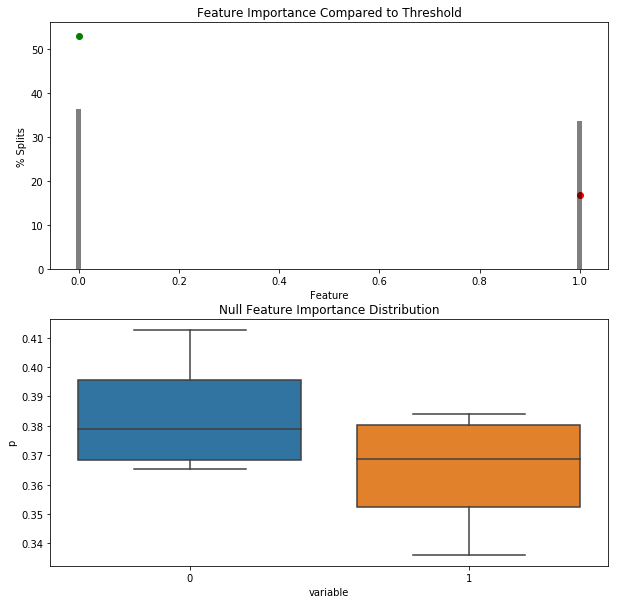

In [11]:
pipeline_model.named_steps["selectnulldistributionthreshold"].plot()

# Feature Selection

The approach so far is useful - but it doesn't give a complete picture of the importance of a single variable.  There are at least two big limitations:
1. % of splits doesn't give up an idea of how much a variable is improving accuracy
2. In cases of high correlation, the model might be able to as easily split on different variables

To get a more direct account of a single variable, we can instead permute that variable, and see how the out of sample RMSE changes.  The bigger the increase in RMSE that scrambling a variable, the more important the variable is.

([1.2875442589640158, 1.5349302151957973],
 [8.694809737061329,
  8.520081849762558,
  8.60005007961278,
  8.926416162399375,
  9.027468430662955,
  8.561770647642888,
  8.727273573769576,
  8.557241867849276,
  8.967567197121092,
  8.567056560102573,
  8.73193296923612,
  8.7067502135217,
  8.972313254229007,
  8.35214212700273,
  8.651288046527648,
  8.724776385402956,
  8.567256962305356,
  8.73687581985247,
  9.05547752801785,
  8.725922157383227])

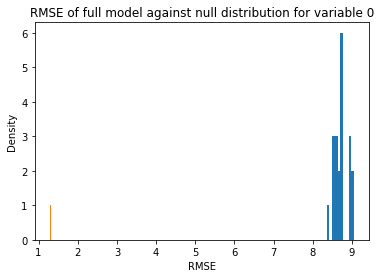

In [51]:
feature_importance(model, X, y, 0)

In [3]:
model = SklearnModel(n_samples=500, n_burn=200, n_trees=20, store_in_sample_predictions=False, n_jobs=-1)
#model_rmses, null_rmses = feature_importance(model, X, y, 1, n_permutations = 2)

In [ ]:
model = SklearnModel(n_samples=500, n_burn=200, n_trees=20, store_in_sample_predictions=False, n_jobs=-1)
feature_importance(model, X, y, 0, n_permutations = 2)

In [95]:
model.fit(X, y)

SklearnModel(alpha=0.95, beta=2.0, n_burn=200, n_chains=4, n_jobs=-1,
       n_samples=500, n_trees=20, p_grow=0.5, p_prune=0.5, sigma_a=0.001,
       sigma_b=0.001, store_in_sample_predictions=False, thin=0.1)

In [150]:
from matplotlib import pyplot as plt

from bartpy.diagnostics.residuals import plot_qq
from bartpy.sklearnmodel import SklearnModel
from typing import List

from matplotlib import pyplot as plt
import numpy as np

from bartpy.model import Model


def plot_tree_depth(model_samples: List[Model], ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    min_depth, mean_depth, max_depth = [], [], []
    for sample in model_samples:
        model_depths = []
        for tree in sample.trees:
            model_depths += [x.depth for x in tree.nodes]
        min_depth.append(np.min(model_depths))
        mean_depth.append(np.mean(model_depths))
        max_depth.append(np.max(model_depths))

    ax.plot(min_depth, label="Min Depth")
    ax.plot(mean_depth, label="Mean Depth")
    ax.plot(max_depth, label="Max Depth")
    ax.set_ylabel("Depth")
    ax.set_xlabel("Iteration")
    ax.legend()
    ax.set_title("Tree Depth by Iteration")
    return ax

def plot_qq(model: SklearnModel, ax=None) -> None:
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    residuals = model.residuals(model.data.X)
    sm.qqplot(residuals, fit=True, line="45", ax=ax)    
    ax.set_title("QQ plot")
    return ax

def plot_sigma_convergence(model: SklearnModel, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    sigma_samples = [x.sigma.current_value() for x in model.model_samples]
    ax.plot(sigma_samples)
    ax.set_title("Sigma Convergence")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Sigma")
    return ax

def plot_diagnostics(model: SklearnModel):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
    plot_qq(model, ax1)
    plot_tree_depth(model.model_samples, ax2)
    plot_sigma_convergence(model, ax3)
    plt.show()

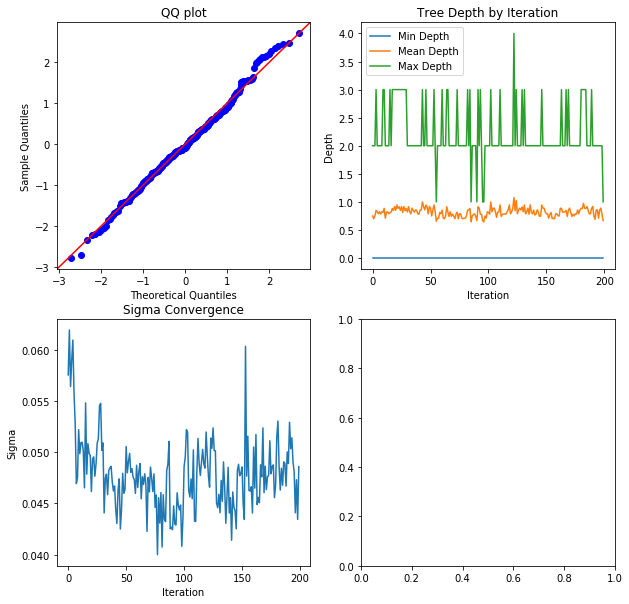

In [151]:
plot_diagnostics(model)

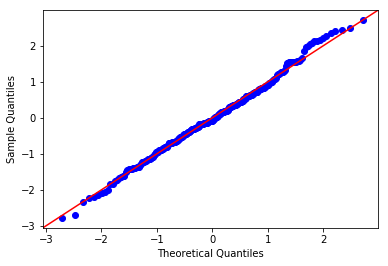

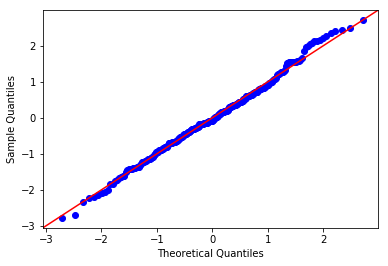

In [120]:
import statsmodels.api as sm

residuals = model.residuals(model.data.X)
sm.qqplot(residuals, fit=True, line="45")

C:\Users\jacoltman\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


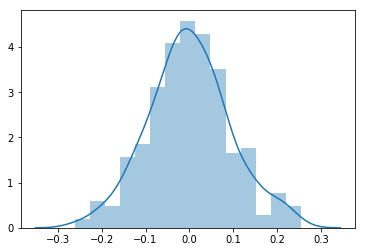

In [145]:
sns.distplot(model.residuals(model.data.X))

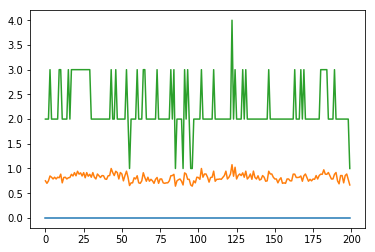

In [130]:
plot_tree_depth(model.model_samples)

In [117]:
model._prediction_samples.mean(axis=0)

C:\Users\jacoltman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
C:\Users\jacoltman\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [118]:
model._prediction_samples

array([], dtype=float64)

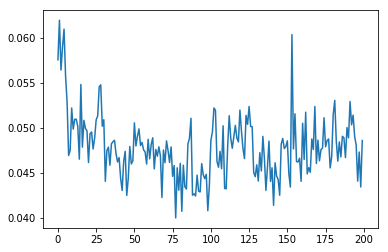

In [149]:
plt.plot([x.sigma.current_value() for x in model.model_samples])

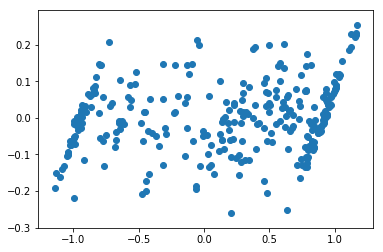

In [154]:
plt.scatter(model.data.unnormalized_y, model.residuals(X))

In [11]:
Parallel(n_jobs=2)(model.f_delayed_chains(X, y))

[([<bartpy.model.Model at 0x170a9f8cd68>,
  array([], dtype=float64)),
 ([<bartpy.model.Model at 0x170a9fe9278>,
  array([], dtype=float64)),
 ([<bartpy.model.Model at 0x170aac4e080>,
  array([], dtype=float64)),
 ([<bartpy.model.Model at 0x170aac46e48>,
  array([], dtype=float64))]